<font size= 10> **Prospect Theory SWB Model Parameter Recovery**


Goal of SWB prospect theory models is to capture individual subject's risk aversion, loss aversion, and choice probability to generate utility-based expected values of each trial for each subject. If recoverable, these models will be used to estimate subjective wellbeing ratings. Here, models are recovered independent from ratings. 

# SWB Prospect Theory Models:
1. Base PT Model
    - free params: loss aversion, risk aversion, temp
2. Dual Risk Aversion PT Model:
    - free params: loss aversion, gain risk aversion, loss risk aversion, temp


Goal of SWB prospect theory models is to capture individual subject's risk aversion, loss aversion, and choice probability to generate utility-based expected values of each trial for each subject. If recoverable, these models will be used to estimate subjective wellbeing ratings. Here, models are validated through behavioral simulations. Simulated agents behavior should reflect sensible decision making and be logically consistent with model parameter values. 

# PT Model Free Parameters 
**Risk Aversion**
- non negative utility exponent 
- risk neutral = 1
- risk seeking > 1
- risk averse < 1
- bounds 0-3 (needs verification, rutledge constrained 0.3-1.3, charpentier 0-3)

**Loss Aversion**
- non negative utility coefficient  
- loss neutral = 1
- loss averse > 1
- loss tolerant < 1
- bounds 0-6 (needs verification, rutledge constrained 0.5-5, charpentier 0-5)

**Inverse Temperature**
- non negative decision stochasticity exponent
- completely random = 0
- completely deterministic for highest value = + inf
- bounds 0-10 (needs verification, some constrain up to 20)



# Recovery Evaluation (for each model): 

1. Input known parameters into the model and use the model to simulate data
2. Run MLE optimization to estimate parameters
3. Test whether the parameters estimated from the simulation datasets are tightly correlated with the known parameters
4. Make figures 

In [1]:
import numpy as np
import random
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize # minimize function is used for parameter recovery 
import seaborn as sns 
import tqdm
from scipy.stats import spearmanr,pearsonr
import statsmodels.api as sm
import os
from scipy.stats import norm
import pickle
import datetime
from joblib import Parallel, delayed
import itertools
from scipy.stats import norm



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils


In [4]:
# get date info for data/fig saving
date = datetime.date.today().strftime('%m%d%Y')
print(date)
# set directories
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
# create fig saving directory
fig_dir = f'{base_dir}swb_computational_modeling/figs/pt_recovery_mle/'
os.makedirs(fig_dir,exist_ok = True) 


01142024


In [5]:
%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")

In [6]:
def simulate_base_pt(params,trials):
    #inputs: 
    #params - risk, loss, temp
    #trials - number of trials for simulation (for EMU SWB always 150)
    risk_aversion, loss_aversion, inverse_temp = params

    # init list of choice prob predictions
    tr = []
    trial_list = []
    choice_prob = []
    choice_pred = []
    util_g = []
    util_s = []
    choice_util = []
    p_g = []
    p_s = []
    safe = []
    high = []
    low = []

    #load task code master df 
    swb_trial_master = pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/swb_trial_master.csv')

    task = swb_trial_master.sample(frac = 1) #randomize task order 

    #loop through trials
    for trial in range(len(task)):

        trial_type = task.TrialType.iloc[trial]
        safe_bet = task.SafeBet.iloc[trial]
        high_bet = task.HighBet.iloc[trial]
        low_bet = task.LowBet.iloc[trial]
        trial_list.append(trial_type)

        safe.append(safe_bet)
        high.append(high_bet)
        low.append(low_bet)


        # transform to high bet value to utility (gamble)
        if high_bet > 0: #mix or gain trials
            weighted_high_bet = 0.5 * ((high_bet)**risk_aversion)
        else: #loss trials
            weighted_high_bet = 0 # -0.5 * loss_aversion * (-high_bet)**risk_aversion - this is never the case so changed to zero 
        
        # transform to low bet value to utility (gamble)
        if low_bet >= 0: #gain trials
            weighted_low_bet = 0 #0.5 * (low_bet)**risk_aversion - this is never the case so changed to zero 
        else: #loss and mix trials
            weighted_low_bet = -0.5 * loss_aversion * ((-low_bet)**risk_aversion)
        
        util_gamble = weighted_high_bet + weighted_low_bet
    

        # transform safe bet value to utility (safe)
        if safe_bet >= 0: #gain or mix trials
            util_safe = (safe_bet)**risk_aversion
        else: #loss trials
            util_safe = -loss_aversion * ((-safe_bet)**risk_aversion)
        
        # utility options for calculating EV - utils separate, ug - us to combine or Uchosen - Unchosen (will differ by participant) 
        #inverse temp < 1 more exporatory, > 1 more exploitative
        # convert EV to choice probabilities via softmax
        p_gamble = np.exp(inverse_temp*util_gamble) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        p_safe = np.exp(inverse_temp*util_safe) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        

        util_g.append(util_gamble)
        util_s.append(util_safe)
        p_g.append(p_gamble)
        p_s.append(p_safe)

        choice = random.choices(['gamble','safe'],weights=[p_gamble,p_safe])[0]
        choice_pred.append(choice)

        if choice == 'gamble':
            choice_prob.append(p_gamble)
            choice_util.append(util_gamble)
        else:
            choice_prob.append(p_safe)
            choice_util.append(util_safe)

        tr.append(trial)



    data = {'tr':tr,'TrialType':trial_list,'GambleChoice':choice_pred,'ChoiceProb':choice_prob, 'ChoiceUtil':choice_util,
                       'util_gamble':util_g,'util_safe':util_s,'p_gamble':p_g,'p_safe':p_s,'SafeBet':safe,'HighBet':high,'LowBet':low}
    DF = pd.DataFrame(data)
    
    return DF

In [7]:
##### MLE parameter estimation for base prospect theory

def fit_base_pt(params, subj_df, prior=None, output='mle'):

    risk_aversion, loss_aversion, inverse_temp = params

    if output == 'npl':
        risk_aversion = norm2riskaversion(risk_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
        risk_aversion_bounds = [0.00001, 2] #set upper and lower bounds
        if risk_aversion< min(risk_aversion_bounds) or risk_aversion> max(risk_aversion_bounds): #prevent estimation from parameter values outside of bounds 
            return 10000000
        
        loss_aversion = norm2lossaversion(loss_aversion) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
        loss_aversion_bounds = [0.00001, 6] #set upper and lower bounds
        if loss_aversion< min(loss_aversion_bounds) or loss_aversion> max(loss_aversion_bounds):  #prevent estimation from parameter values outside of bounds 
            return 10000000
        
        inverse_temp = norm2invtmp(inverse_temp) #transform parameter from gaussian space back into native model space using parameter-specific sigmoid function
        this_beta_bounds = [0.00001, 8]  #set upper and lower bounds
        if inverse_temp < min(this_beta_bounds) or inverse_temp > max(this_beta_bounds):  #prevent estimation from parameter values outside of bounds 
            return 10000000

    #Initialize choice probability vector to calculate negative log likelihood
        # actual subj choice info   
    choice_list = []
    choice_prob_list = []
        # predicted subj choice info 
    choice_pred_list = []
    choice_pred_prob = []

    #Initialize empty data vectors to return all relevant data if output = 'all'
    tr          = []
    trial_list  = []
    util_g      = []
    util_s      = []
    choice_util = []
    p_g         = []
    p_s         = []
    safe        = []
    high        = []
    low         = []
    w_safe      = []
    w_high      = []
    w_low       = []
    

    for trial in range(len(subj_df)):

        trial_info = subj_df.iloc[trial]
        trial_type = trial_info['TrialType']
        choice = trial_info['GambleChoice']
        high_bet = trial_info['HighBet']
        low_bet = trial_info['LowBet']
        safe_bet = trial_info['SafeBet']


        #store trial info 
        choice_list.append(choice)
        tr.append(trial)
        trial_list.append(trial_type)
        high.append(high_bet)
        low.append(low_bet)
        safe.append(safe_bet)

        ##### Utility calculations #####

        # transform to high bet value to utility (gamble)
        if high_bet > 0: #mix or gain trials
            weighted_high_bet = 0.5 * ((high_bet)**risk_aversion)
        else: #loss trials
            weighted_high_bet = 0 
        
        w_high.append(weighted_high_bet)

        # transform to low bet value to utility (gamble)
        if low_bet < 0: #loss and mix trials
            weighted_low_bet = -0.5 * loss_aversion * ((-low_bet)**risk_aversion)
            
        else: #gain trials
            weighted_low_bet = 0 
        
        w_low.append(weighted_low_bet)
        
        util_gamble = weighted_high_bet + weighted_low_bet
        util_g.append(util_gamble)
    

        # transform safe bet value to utility (safe)
        if safe_bet >= 0: #gain or mix trials
            util_safe = (safe_bet)**risk_aversion
        else: #loss trials
            util_safe = -loss_aversion * ((-safe_bet)**risk_aversion)

        w_safe.append(util_safe)
        util_s.append(util_safe)


        ##### Choice probability calculation #####

        # convert EV to choice probabilities via softmax
        p_gamble = np.exp(inverse_temp*util_gamble) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )
        p_safe = np.exp(inverse_temp*util_safe) / ( np.exp(inverse_temp*util_gamble) + np.exp(inverse_temp*util_safe) )

        # append probability of chosen options
        if choice == 'gamble':
            choice_prob_list.append(p_gamble)
            choice_util.append(util_gamble)

        elif choice == 'safe':
            choice_prob_list.append(p_safe)
            choice_util.append(p_safe)
        
        
        #getting stochastic predictions of model 
        choice_pred = random.choices(['gamble','safe'],weights=[p_gamble,p_safe])[0]
        choice_pred_list.append(choice_pred)

        if choice_pred == 'gamble':
            choice_pred_prob.append(p_gamble)
        else:
            choice_pred_prob.append(p_safe)



    # calculate negative log likelihood of choice probabilities 
            
    negll = -np.sum(np.log(choice_prob_list))
    
    if np.isnan(negll):
        negll = np.inf
    
    # output for MLE optimization
    if output == 'mle': 
        return negll
    
    # output for fitting 
    elif output == 'all': 
        subj_dict = {'params'         : [risk_aversion, loss_aversion, inverse_temp],
                     'tr'             : tr,
                     'TrialType'      : trial_list,
                     'GambleChoice'   : choice_list,
                     'ChoiceProb'     : choice_prob_list,
                     'ChoiceUtil'     : choice_util,
                     'ChoicePred'     : choice_pred,
                     'ChoicePredProb' : choice_pred_prob,
                     'util_gamble'    : util_g,
                     'util_safe'      : util_s, 
                     'p_gamble'       : p_g,
                     'p_safe'         : p_s,
                     'HighBet'        : high,
                     'LowBet'         : low,
                     'SafeBet'        : safe,
                     'WeightedHigh'   : w_high,
                     'WeightedLow'    : w_low,
                     'WeightedSafe'   : w_safe,
                     'negll'          : negll,
                     'BIC'            : len(params) * np.log(150) + 2*negll,
                     'AIC'            : 2*len(params) + 2*negll}
        return subj_dict
    
    # output for EM MAP optimization
    elif output == 'npl':
        if prior is not None:  # EM-fit: P(Choices | h) * P(h | O) should be maximised, therefore same as minimizing it with negative sign
            fval = -(-negll + prior['logpdf'](params))

            if any(prior['sigma'] == 0):
                this_mu = prior['mu']
                this_sigma = prior['sigma']
                this_logprior = prior['logpdf'](params)
                print(f'mu: {this_mu}')
                print(f'sigma: {this_sigma}')
                print(f'logpdf: {this_logprior}')
                print(f'fval: {fval}')
            
            if np.isinf(fval): 
                fval = 10000000
            return fval
        else: # NLL fit 
            return negll
    
    
##### MLE parameter estimation for base prospect theory

def minimize_negll(func_obj, param_values, df, param_bounds):
    # minimize negll via MLE via gradient descent

    result = minimize(func_obj, 
                      param_values, 
                      df,
                      bounds=param_bounds)
    return result
    


def parallel_run_base_pt(min_fn, fit_fn,param_combo_guesses,param_bounds,subj_df,n_jobs=-2):
    '''
    Maximum likelihood estimation with parallel processing 

    Inputs:
        - min_fn: minimization function 
        - fit_fn: model fitting function (should return negll only)
        - param_combo_guesses: grid of initial param values for parallel min_fn runs 
        - param_bounds: min/max bounds for params in this format: (0,5),(0,5),(0,10)
        - subj_df: pandas df of subj task data
    
    Returns:
        - fit_dict: output of fit_fn

    '''

    
    ##### Minimize negll via parallel mle

    # Parallel fn :
        # Basic syntax Parallel(n_jobs,verbose) ( delayed(optim_fn)(optim_fun inputs) loop for parallel fn inputs )
        # requires Parallel & delayed from joblib
        # n_jobs=-2 - num cpus used, -1 for all, -2 for all but one, +num for specific num
        # verbose default is none, higher than 10 will give all
        # delayed() = hold memory for function to run in parallel
        # optim_fn = minimization fn
        # ()() = inputs for optim_fn in delay - negll fn, params, data, bounds
        # (()()____): iterations of initial param values 
    
    results = Parallel(n_jobs=n_jobs, verbose=5)(delayed(min_fn)(fit_fn, param_values, (subj_df), param_bounds) for param_values in param_combo_guesses)

    # determine optimal parameter combination from negll
    fit_dict = {}
    best_result = min(results, key=lambda x: x.fun) # use lambda function to get negll from each run in results (lambda args: expression) 
    param_fits = best_result.x
    fit_dict['best_result'] = best_result
    # run fit_fn with param_fits get best model fit info ### implement this with GLMs!
    fit_dict['subj_dict'] = fit_fn(param_fits, subj_df, output='all')
    
    
    return fit_dict

# Import Simulation Data Used for EM Map Recovery

In [9]:
emmap_path = f'{base_dir}swb_computational_modeling/swb_behav_models/data/pt_recovery_emmap/'
mle_recovery_emmap_sim_dict = pickle.load(open(f'{emmap_path}swb_emmap_recovery_sim_inputs_01142024.pkl','rb')) 

mle_recovery_emmap_sim_dict

{(0.6805453108160158,
  0.01,
  2.200810742980015):       tr TrialType GambleChoice  ChoiceProb  ChoiceUtil  util_gamble  \
 0      0       mix       gamble    0.621821    0.225956     0.225956   
 1      1       mix       gamble    0.822811    0.697701     0.697701   
 2      2       mix       gamble    0.681956    0.346588     0.346588   
 3      3      gain         safe    0.584471    0.623929     0.468917   
 4      4      loss         safe    0.498883   -0.007064    -0.005034   
 ..   ...       ...          ...         ...         ...          ...   
 145  145      gain         safe    0.452730    0.440714     0.526886   
 146  146       mix       gamble    0.615494    0.213768     0.213768   
 147  147      gain       gamble    0.502604    0.628661     0.628661   
 148  148      loss         safe    0.499292   -0.004407    -0.003120   
 149  149      gain         safe    0.476835    0.440714     0.482847   
 
      util_safe  p_gamble    p_safe  SafeBet  HighBet  LowBet  
 0     

# Fit Pt Model w MLE

In [10]:
# initial param values (same as subj fitting)
risk_inits     = np.linspace(.1,1.75,4)
loss_inits     = np.linspace(.1,5,4)
invtemp_inits = np.linspace(.75,8,4)
print(risk_inits,loss_inits,invtemp_inits)

[0.1  0.65 1.2  1.75] [0.1        1.73333333 3.36666667 5.        ] [0.75       3.16666667 5.58333333 8.        ]


In [11]:
#### run MLE optimization

recovery_MLE_dict = {}
# specify param bounds (risk_aversion, loss_aversion, inverse_temperature)
param_bounds = ((0.00001, 2), (0.00001, 6), (0.00001, 10))

for params in list(mle_recovery_emmap_sim_dict.keys()):
    # make grid of param values > itertools object disappears if used? 
    param_combo_guesses = itertools.product(risk_inits,loss_inits,invtemp_inits)
    #get agent df 
    sim_df = mle_recovery_emmap_sim_dict[params]
    sim_fit_dict = parallel_run_base_pt(minimize_negll, fit_base_pt, param_combo_guesses, param_bounds, sim_df, n_jobs=-2)
    recovery_MLE_dict[params] = sim_fit_dict

recovery_MLE_dict

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:    9.3s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   17.9s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   17.9s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   12.1s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done  64 out of  64 | elapsed:   18.1s remain

{(0.6805453108160158,
  0.01,
  2.200810742980015): {'best_result':   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
    success: True
     status: 0
        fun: 99.28521254985125
          x: [ 4.595e-01  1.000e-05  2.037e+00]
        nit: 8
        jac: [ 0.000e+00  6.699e-01  0.000e+00]
       nfev: 48
       njev: 12
   hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>, 'subj_dict': {'params': [0.45951927353470756,
    1e-05,
    2.036615256800901],
   'tr': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
 

In [12]:
save_path = f'{base_dir}swb_computational_modeling/swb_behav_models/data/pt_recovery_emmap/'

# create a binary pickle file 
f = open(f'{save_path}/mle_recovery_emmap_sim_fits.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(recovery_MLE_dict,f)
# # close file
f.close()

# Compare Known Simulation Parameters and Model Fit Output

In [16]:
# extract estimated params for all subj
risk_est    = []
loss_est    = []
invtemp_est = []


for params in recovery_MLE_dict.keys():
    fit = recovery_MLE_dict[params]
    sim_fit_dict = fit['subj_dict']
    risk_est.append(sim_fit_dict['params'][0])
    loss_est.append(sim_fit_dict['params'][1])
    invtemp_est.append(sim_fit_dict['params'][2])



In [17]:
# extract known simulation parameters as lists 
risk_known    = []
loss_known    = []
invtemp_known = []


for params in mle_recovery_emmap_sim_dict.keys():
    risk_known.append(params[0])
    loss_known.append(params[1])
    invtemp_known.append(params[2])

# print(risk_known,loss_known,invtemp_known)


In [18]:
list(zip(risk_known,risk_est))

[(0.6805453108160158, 0.45951927353470756),
 (0.9535620679214342, 0.7718856518153332),
 (1.0624715709677217, 1.061814626207303),
 (0.3642495526624653, 0.3756173456240103),
 (1.3214220960010268, 1.3736339101802675),
 (0.9988349607284269, 1.1240535973758947),
 (1.175612274175193, 1.4143980982310003),
 (1.1518518572593723, 1.7931434998006364),
 (0.9015313355215058, 0.9276960600640783),
 (1.2700681888144605, 1.4714991569504423),
 (0.8988532703877311, 2.0),
 (0.8933553094091398, 0.8827443364864389),
 (1.0850689225981323, 0.9207834959239053),
 (1.3892498169500083, 0.6997722950239416),
 (1.124158599463332, 0.9915465849480615),
 (1.3976951815443333, 1.2702066482898942),
 (1.058241232117049, 0.7650118828436611),
 (1.1441734872746416, 1.1546993996601351),
 (0.8392473487374654, 0.7484543845448106),
 (1.1762117766811226, 1.3639529989770796),
 (0.9320497343551555, 0.7583987379953584),
 (1.248984852723407, 1.1768428063207161),
 (0.76000739861575, 1.0222973026523596),
 (0.43395581376342174, 0.4855390

In [25]:
fig_dir = f'{base_dir}swb_computational_modeling/figs/pt_recovery_emmap/'


In [20]:
risk_corr, risk_p = spearmanr(risk_known,risk_est)
print('Spearman correlation: %.3f' % risk_corr)
print(risk_p)

Spearman correlation: 0.751Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

2.3049954141092047e-19


In [ ]:
emmap_sim

In [24]:
fig_dir

'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/figs/pt_recovery_mle/'

In [27]:
f'{fig_dir}risk_aversion_mle_recovery_emmap_sim_{date}.pdf'

'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/figs/pt_recovery_emmap/risk_aversion_mle_recovery_emmap_sim_01142024.pdf'

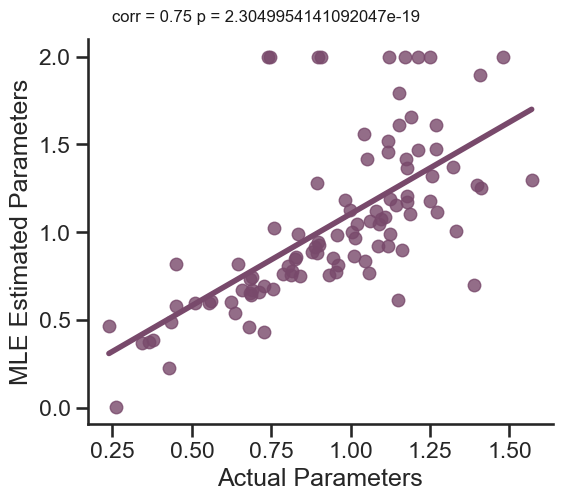

In [26]:
#plot estimated risk aversion parameters with known risk aversion parameters

fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=risk_known, y=risk_est, color = '#78496b',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.25, 2.2,f'corr = {np.round(risk_corr,2)} p = {risk_p}',fontsize=12,color = 'k')
plt.xlabel('Actual Parameters')
plt.ylabel('MLE Estimated Parameters')
sns.despine()


plt.savefig(f'{fig_dir}risk_aversion_mle_recovery_emmap_sim_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [28]:
loss_corr, loss_p = spearmanr(loss_known,loss_est)
print('Spearman correlation: %.3f' % loss_corr)
print(loss_p)

Spearman correlation: 0.953Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

1.4116932005220357e-52


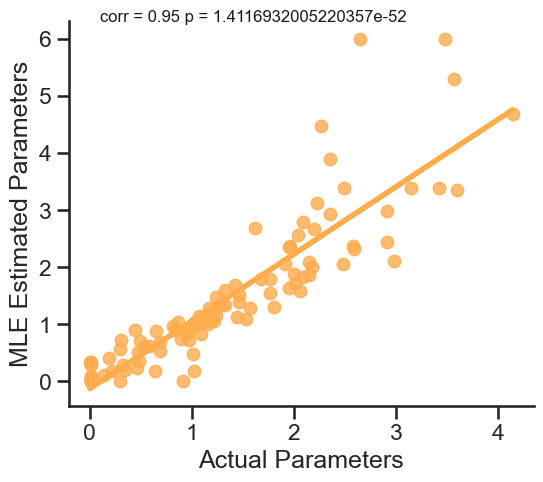

In [29]:
#plot estimated loss aversion parameters with known loss aversion parameters

fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=loss_known, y=loss_est, color = '#ffac4d',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 6.3,f'corr = {np.round(loss_corr,2)} p = {loss_p}',fontsize=12,color = 'k')
plt.xlabel('Actual Parameters')
plt.ylabel('MLE Estimated Parameters')
sns.despine()


plt.savefig(f'{fig_dir}loss_aversion_mle_recovery_emmap_sim__{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 


#### keep inverse temp above 0.5 

In [30]:
invtemp_corr, invtemp_p = spearmanr(invtemp_known,invtemp_est)
print('Spearman correlation: %.3f' % invtemp_corr)
print(invtemp_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.693
1.4009201948519506e-15


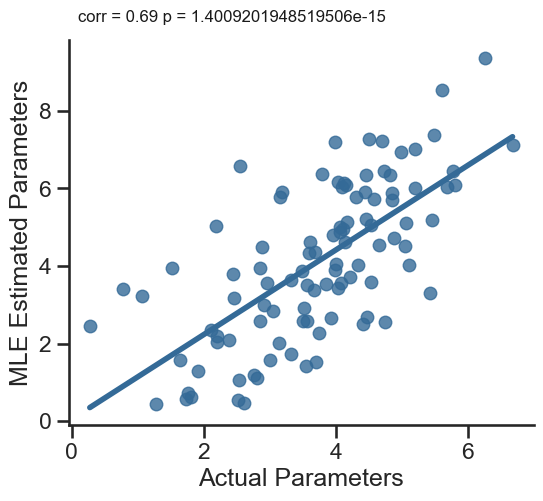

In [31]:
#plot estimated inverse temp parameters with known inverse temp parameters

# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=invtemp_known, y=invtemp_est, color = '#346a97',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 10.3,f'corr = {np.round(invtemp_corr,2)} p = {invtemp_p}',fontsize=12,color = 'k')
plt.xlabel('Actual Parameters')
plt.ylabel('MLE Estimated Parameters')
sns.despine()


plt.savefig(f'{fig_dir}inverse_temperature_mle_recovery_emmap_sim__{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 
